<img width="6%" alt="pyTCR.png" src="./images/logo.png" style="border-radius: 15%">

# PyTCR - Example 1: Tropical cyclones tracks and intensity

**Author:** [Phong Le](https://github.com/levuvietphong)

**Description:** This notebook load and visualize tropical cyclone tracks obtained from an open-source, statistical-dynamical [tropical cyclone downscaling model](https://github.com/linjonathan/tropical_cyclone_risk) with intensity-dependent steering. The downscaling model is entirely forced by the large-scale environment from ERA5-reanalysis or CMIP6 models.

### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,glob
sys.path.append(os.path.abspath(os.path.join('..')))
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import colorcet as cc
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

import src.iodata as tcr_io
import src.plots as tcr_plot
import src.physics as tcr_physics

### Map and plot configurations

In [2]:
# Map projection - here we focus on North Atlantic here
projection = ccrs.AzimuthalEquidistant(central_longitude=-50, central_latitude=30)

# Map boundaries (in degree)
xmin = -100; xmax = 0; dx = 20
ymin = 0; ymax = 60; dy = 10
extent = [xmin, xmax, ymin, ymax, dx, dy]
basin = 'NA'       # North Atlantic

# Density and filtering
cellsize = 2        # Size of the lat-lon box for counting number of tracks.

# Shapefiles for plotting maps
shapefile = '../data/shapefiles/CONUS.shp'      # Continental United States
shpCONUS = shpreader.Reader(shapefile)

# Time plot
year_s = 1964
year_e = 2014
num_year = year_e - year_s + 1

### Tropical cyclone observations
Data collected in the [International Best Track Archive for Climate Stewardship (IBTrACS) project](https://www.ncei.noaa.gov/products/international-best-track-archive) as tropical cyclone observations. This project merges recent and historical tropical cyclone data from multiple agencies to create a unified, publicly available, best-track dataset that improves inter-agency comparisons.

In [3]:
# Observed filename
fname = '../data/observations/IBTrACS.NA.v04r00.nc'

# Load the observed best tracks
lat_obs, lon_obs, time_obs, id_obs, storm_names_obs, basin_names_obs, \
    vmax_obs, storm_speed_obs = tcr_io.load_best_tracks_obs(fname, year_s, year_e)

# Estimate Power Dissipitation Index (PDI) from observations
num_obs = len(id_obs)
lat_obs_cs, lon_obs_cs, pdi_obs = tcr_physics.estimate_pdi(lat_obs, lon_obs, vmax_obs, num_obs, cellsize=2, dt=3)        # 2 degree, 3-hour interval

### Tropical cyclone downscaled from Reanalysis-ERA5
This dataset is the outputs of the tropical cyclone downscaling model forced by large-scale environment obtained from the [Reanalysis-ERA5](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5) dataset during historical period. 

In [4]:
# Specify model name, experiment, and data location
model = 'REANALYSIS'
expmnt = 'historical'
pathdir = '../data/downscaled/'

# Load the tracks
lat_rea, lon_rea, year_rea, id_rea, vmax_rea = tcr_io.load_tracks_GCMs(pathdir, model, basin, expmnt)

# Estimate Power Dissipitation Index (PDI) from reanalysis
# Since observations have less tracks than in model and reanalysis, we use the same num_obs for estimating PDI
lat_rea_cs, lon_rea_cs, pdi_rea = tcr_physics.estimate_pdi(lat_rea, lon_rea, vmax_rea, num_obs, cellsize=2, dt=1)        # 1-hour interval

### Tropical cyclone data downscaled from CMIP6 models
This dataset is the outputs of the tropical cyclone downscaling model forced by large-scale environment obtained from the different [CMIP6 models](https://pcmdi.llnl.gov/CMIP6/). Here, the [E3SM version 1.0](https://e3sm.org/) is demonstrated but the notebook is applicable to other CMIP6 models.

In [5]:
# CMIP6 models
model = 'E3SM-1-0'
expmnt = 'historical'
pathdir = '../data/downscaled/'

# Load the modeled tracks
lat_mod, lon_mod, year_mod, id_mod, vmax_mod = tcr_io.load_tracks_GCMs(pathdir, model, basin, expmnt)

# Estimate Power Dissipitation Index (PDI) from model
# Since observations have less tracks than in model and reanalysis, we use the same num_obs for estimating PDI
lat_mod_cs, lon_mod_cs, pdi_mod = tcr_physics.estimate_pdi(lat_mod, lon_mod, vmax_mod, num_obs, cellsize=2, dt=1)        # 1-hour interval

### Set up plot and identify tracks landfalling Texas
Due to the large number of tropical cyclones over the historical period, we randomly select 250 tracks to enhance visualization clarity.

In [6]:
# Load Texas state shapefile
gpd_CONUS = gpd.read_file(shapefile)
gpd_TX = gpd_CONUS[gpd_CONUS['NAME']=='Texas']
poly_TX = gpd_TX.geometry

# Plot parameters
num_tracks_plot = 250       # Number of tracks to plot
norm = plt.Normalize(0, 80)

# Get the track ids over the same number of TCs that landfall on TX
ind_TX_mod = tcr_plot.get_tracks_landfall_region(lat_mod, lon_mod, num_obs, poly_TX)
ind_TX_rea = tcr_plot.get_tracks_landfall_region(lat_rea, lon_rea, num_obs, poly_TX)
ind_TX_obs = tcr_plot.get_tracks_landfall_region(lat_obs, lon_obs, num_obs, poly_TX)

# Randomly select a subset of tracks (without replacement) for visualization
ind_mod = np.random.choice(id_mod, num_tracks_plot, replace=False)
ind_rea = np.random.choice(id_rea, num_tracks_plot, replace=False)
ind_obs = np.random.choice(id_obs, num_tracks_plot, replace=False)

### Plotting tropical cyclone tracks
We show tropical cyclones over the North Atlantic ocean and highlight those that made landfall in Texas, USA. The color  represents the maximum circular wind speed for the storm.

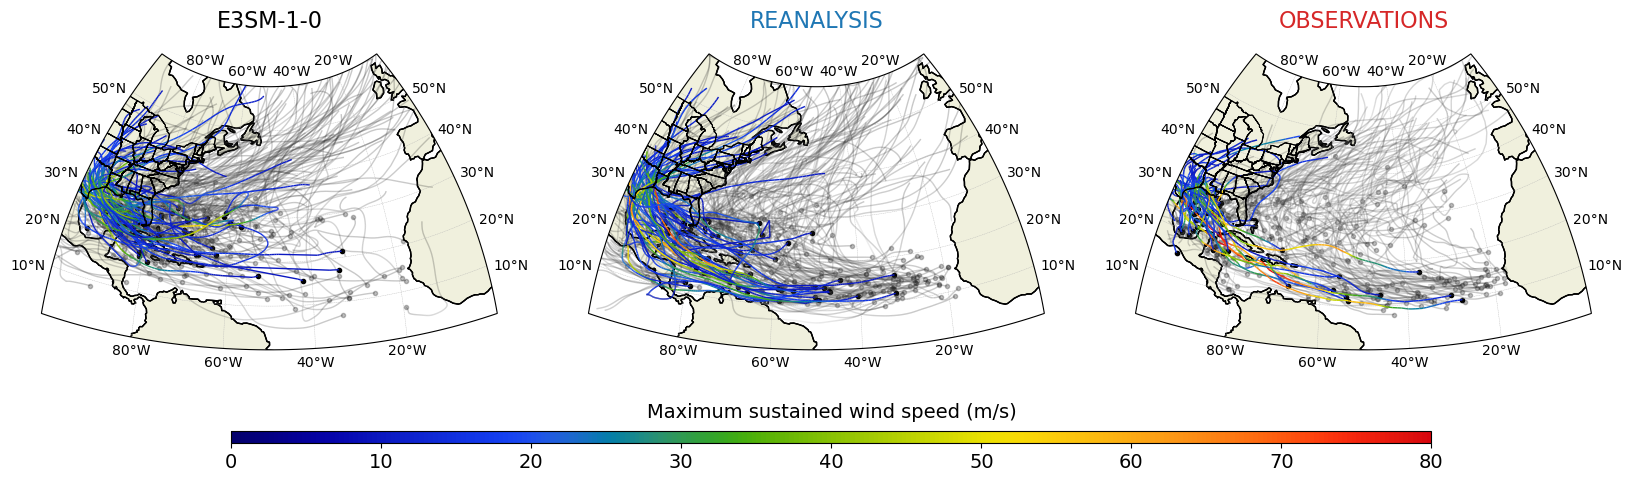

In [7]:
cmap = cc.cm.CET_R4
fig, ax = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection=projection))

# PLOT MODEL TRACKS ------------------------------------------------------------------
# First, plot all tracks in gray. Second, plot tracks landfalling on TX in color
_ = tcr_plot.plot_tracks(ax[0], lat_mod, lon_mod, vmax_mod, ind_mod, interval=3, wind_speed_threshold=10, 
                         extent=extent, shapefile=shpCONUS, norm=norm)

im = tcr_plot.plot_tracks(ax[0], lat_mod, lon_mod, vmax_mod, ind_TX_mod[:50], interval=2, wind_speed_threshold=10, 
                          extent=extent, cmap=cmap, show_gridlabel=True, shapefile=shpCONUS,
                          title=model, title_ypos=1.03, wind_color=True, title_fontcolor='k', norm=norm)


# PLOT REANALYSIS TRACKS ------------------------------------------------------------------
_ = tcr_plot.plot_tracks(ax[1], lat_rea, lon_rea, vmax_rea, ind_rea, interval=1, wind_speed_threshold=10,
                         extent=extent, shapefile=shpCONUS, norm=norm)

_ = tcr_plot.plot_tracks(ax[1], lat_rea, lon_rea, vmax_rea, ind_TX_rea[:50], interval=2, wind_speed_threshold=10, 
                         extent=extent, cmap=cmap, show_gridlabel=True, shapefile=shpCONUS,
                         title='REANALYSIS', title_ypos=1.03, wind_color=True, title_fontcolor='tab:blue', norm=norm)


# PLOT OBSERVATIONS TRACKS ------------------------------------------------------------------
_ = tcr_plot.plot_tracks(ax[2], lat_obs, lon_obs, vmax_obs, ind_obs, interval=1, wind_speed_threshold=10, 
                         extent=extent, shapefile=shpCONUS, norm=norm)

_ = tcr_plot.plot_tracks(ax[2], lat_obs, lon_obs, vmax_obs, ind_TX_obs[:50], interval=1, wind_speed_threshold=10, 
                         extent=extent, cmap=cmap, show_gridlabel=True, shapefile=shpCONUS, 
                         title='OBSERVATIONS', title_ypos=1.03, wind_color=True, title_fontcolor='tab:red', norm=norm)


# COLORBAR
cbax = fig.add_axes([0.22, 0.0, 0.6, 0.024])
cb = fig.colorbar(im, cax=cbax, orientation='horizontal')
cb.set_label(r'Maximum sustained wind speed (m/s)', fontsize=14, labelpad=-50)
cb.set_ticks(np.linspace(0, 80, 9))
cb.ax.tick_params(labelsize=14)

### Plot tropical cyclone Power Dissipitation Index
The PDI is based on storm frequency, wind speed, and duration. It places more emphasis on storm intensity by using the cube of the wind speed rather than the wind speed squared as in the ACE index. A complete description of how the PDI is calculated can be found [here](https://www.nature.com/articles/nature03906).

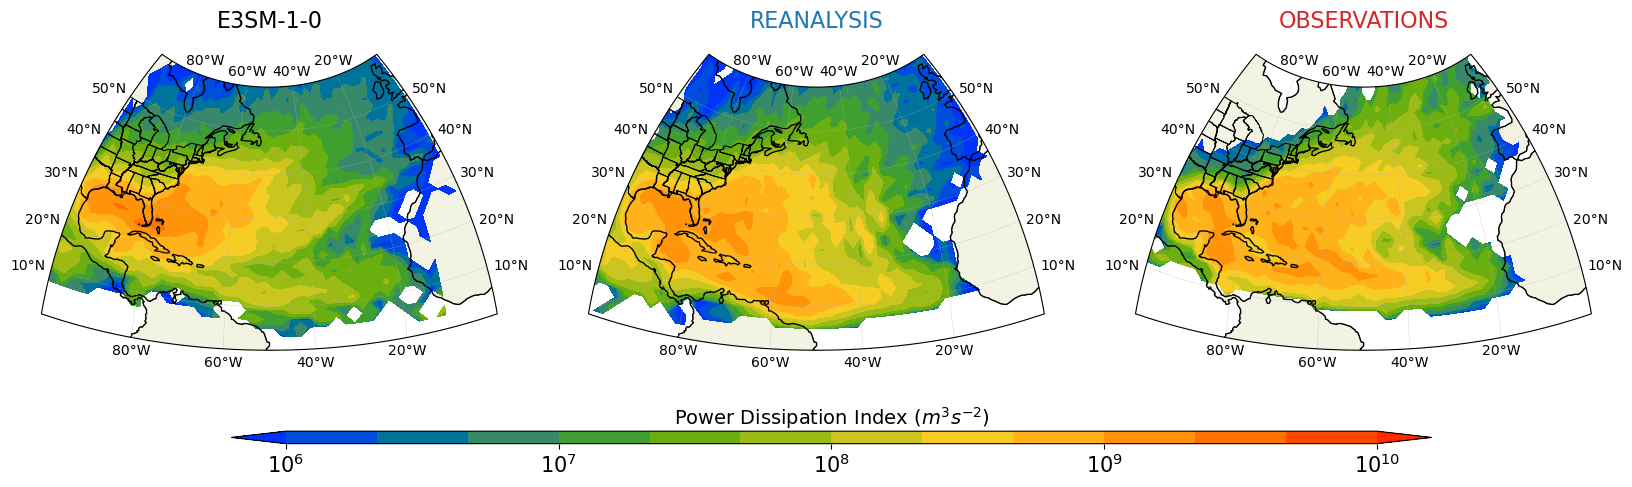

In [8]:
levels = np.logspace(6,10,13)
cmap = cc.cm.rainbow
fig, ax = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection=projection))

# MODEL
im = tcr_plot.plot_density(ax[0], lat_mod_cs, lon_mod_cs, pdi_mod/num_year, levels, extent=extent, cmap=cmap,
                          logscale=True, show_gridlabel=True, shapefile=shpCONUS, title=model, title_ypos=1.03, title_fontcolor='k')

# REANALYSIS
_ = tcr_plot.plot_density(ax[1], lat_rea_cs, lon_rea_cs, pdi_rea/num_year, levels, extent=extent, cmap=cmap,
                          logscale=True, show_gridlabel=True, shapefile=shpCONUS, title='REANALYSIS', title_ypos=1.03, title_fontcolor='tab:blue')

# OBSERVATIONS
_ = tcr_plot.plot_density(ax[2], lat_obs_cs, lon_obs_cs, pdi_obs/num_year, levels, extent=extent, cmap=cmap,
                          logscale=True, show_gridlabel=True, shapefile=shpCONUS, title='OBSERVATIONS', title_ypos=1.03, title_fontcolor='tab:red')

# COLORBAR
cbax = fig.add_axes([0.22,0.0,0.6,0.025])
cb = fig.colorbar(im, cax=cbax, orientation='horizontal')
cb.set_label(r'Power Dissipation Index ($m^3 s^{-2}$)', fontsize=14, labelpad=-52)
cb.set_ticks(np.logspace(6,10,5))
cb.set_ticklabels([r'$10^{6}$',r'$10^{7}$',r'$10^{8}$',r'$10^{9}$',r'$10^{10}$'])
cb.ax.tick_params(labelsize=15)